In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

In [27]:
# data prep and model-tuning
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# types of models we'll fit
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

from scipy.stats import shapiro

import pickle
from copy import deepcopy

## Our Data

In [28]:
DATA = '../data/processed/training_data_annual.csv'
df = pd.read_csv(DATA)
df = df.dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

3,529 samples
Columns: ['uuid' 'lidar_year' 'lat' 'lon' 'orig_id' 'source' 'meas_yr' 'ecoregion3'
 'agency' 'plot_size_ac' 'num_returns' 'strat0_return-proportion'
 'strat1_return-proportion' 'strat2_return-proportion'
 'strat3_return-proportion' 'strat4_return-proportion'
 'strat5_return-proportion' 'skewness' 'kurtosis'
 'strat0_intensity-median' 'strat1_intensity-median'
 'strat2_intensity-median' 'strat3_intensity-median'
 'strat4_intensity-median' 'strat5_intensity-median'
 'height_05-percentile' 'height_25-percentile' 'height_50-percentile'
 'height_75-percentile' 'height_95_percentile' 'height_max' 'cover'
 'lidar_acq' 'potential_volume' 'stddev_height' 'surface_area_ratio'
 'surface_volume' 'surface_volume_ratio' 'aspect' 'elevation'
 'overall_curvature' 'plan_curvature' 'profile_curvature' 'slope'
 'solar_radiation_index' 'mat' 'mwmt' 'mcmt' 'td' 'map' 'msp' 'ahm' 'shm'
 'dd_0' 'dd5' 'dd_18' 'dd18' 'nffd' 'bffp' 'effp' 'ffp' 'pas' 'emt' 'ext'
 'eref' 'cmd' 'rh' 'dormancy' 'evi

## Filter out some of the training data
We can exclude some of the training data based on how far separated the inventory data (interpolated using FVS simulations) is from the year the lidar was collected. Similarly, we can screen out training examples that had relatively low density of lidar returns.

In [29]:
df['year_diff'] = abs(df['fvs_year'] - df['lidar_year']).astype(int)

In [30]:
len(df.loc[df['year_diff'] >= 5])

224

In [31]:
df = df.loc[df['year_diff'] < 5]

In [32]:
len(df.loc[df['returns_per_m2'] < 4.0])

93

In [33]:
df = df.loc[df['returns_per_m2'] >= 4.0]

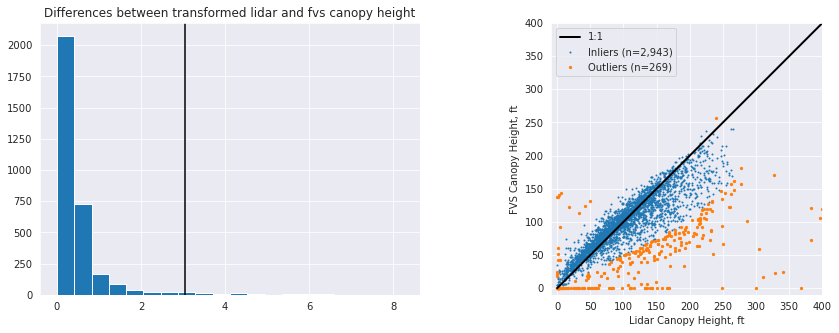

In [34]:
lidar_height_transformer = QuantileTransformer(output_distribution='normal').fit(df['height_95_percentile'].values.reshape(-1, 1))
fvs_height_transformer = QuantileTransformer(output_distribution='normal').fit(df['topht'].values.reshape(-1, 1))

lidar_height_transformed = lidar_height_transformer.transform(df['height_95_percentile'].values.reshape(-1, 1))
fvs_height_transformed = fvs_height_transformer.transform(df['topht'].values.reshape(-1, 1))

diff_height_transformed = abs(lidar_height_transformed - fvs_height_transformed)


fig, axs = plt.subplots(1,2, figsize=(15,5))

# select outliers
OUTLIER_THRESH = 3.05
outliers = diff_height_transformed > OUTLIER_THRESH
outliers = np.logical_or(outliers, (df['height_95_percentile'] > 275/3.28084).values.reshape(-1, 1))
outliers = np.logical_or(outliers, ((df['height_95_percentile'] < 60/3.28084) & (df['topht'] > 105)).values.reshape(-1, 1))
outliers = np.logical_or(outliers, ((df['height_95_percentile'] < 10/3.28084) & (df['topht'] > 40)).values.reshape(-1, 1))
outliers = np.logical_or(outliers, ((abs(df['height_95_percentile']*3.28084 - df['topht'])/df['topht']) > 1.0).values.reshape(-1, 1))
outliers = np.logical_or(outliers, ((abs(df['height_95_percentile']*3.28084 - df['topht'])) > 100).values.reshape(-1, 1))

axs[0].hist(diff_height_transformed, bins=20)
axs[0].axvline(OUTLIER_THRESH, color='k')
axs[0].set_title('Differences between transformed lidar and fvs canopy height')

axs[1].scatter(df['height_95_percentile'].values.reshape(-1, 1)[~outliers]*3.28084, 
            df['topht'].values.reshape(-1, 1)[~outliers],
            s=1, label='Inliers (n={:,d})'.format((~outliers).sum()))

axs[1].scatter(df['height_95_percentile'].values.reshape(-1, 1)[outliers]*3.28084, 
            df['topht'].values.reshape(-1, 1)[outliers],
            s=5, label='Outliers (n={:,d})'.format(outliers.sum()))

axs[1].set_xlabel('Lidar Canopy Height, ft')
axs[1].set_ylabel('FVS Canopy Height, ft')
axs[1].plot([0,400],[0,400], color='k', lw=2, label='1:1')
axs[1].set_xlim(-10, 400)
axs[1].set_ylim(-10, 400)
axs[1].set_aspect('equal')
axs[1].legend();

In [35]:
pd.DataFrame(np.unique(df[outliers]['uuid']), 
             columns=['outlier_uuid'])\
.to_csv('../data/interim/outlier_uuids.csv', index=False)

In [36]:
# filter out the height outliers
df = df[~outliers]

## Inspect how many samples we have for different years, regions, etc.

In [37]:
df.groupby(by=['lidar_year'])[['uuid']].count().rename({'uuid':'count'}, axis=1)

,count
lidar_year,
2008,686
2009,12
2010,2
2011,76
2012,527
2013,199
2014,298
2015,475
2016,478


In [38]:
pd.pivot_table(df, 
               values='uuid', 
               aggfunc='count', 
               index=['meas_yr'], 
               columns=['lidar_year'], 
               fill_value=0)

lidar_year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
meas_yr,,,,,,,,,,,
2010,395,0,0,0,2,0,2,6,0,0,0
2011,291,0,0,0,1,0,2,1,0,0,0
2013,0,12,0,33,345,45,3,6,13,25,2
2014,0,0,2,26,124,39,28,38,83,34,0
2015,0,0,0,17,16,12,15,122,95,24,2
2016,0,0,0,0,39,73,39,214,63,32,21
2017,0,0,0,0,0,30,163,47,78,40,0
2018,0,0,0,0,0,0,46,41,146,10,0


In [39]:
ecoreg_counts = df.groupby(by=['ecoregion3'])[['uuid', 'lidar_acq', 'lidar_year', 'plot_size_ac']].nunique()
ecoreg_counts

,uuid,lidar_acq,lidar_year,plot_size_ac
ecoregion3,,,,
blue_mountains,29,2,2,1
cascades,480,21,9,3
coast_range,1399,18,9,2
columbia_plateau,4,3,3,1
eastern_cascades_slopes_and_foothills,124,9,5,2
klamath_mountains_california_high_north_coast_range,190,6,5,2
north_cascades,339,18,6,2
northern_rockies,68,4,3,1
puget_lowland,106,13,7,1


In [40]:
df[['uuid', 'lidar_acq', 'lidar_year', 'plot_size_ac']].nunique()

uuid            2780
lidar_acq         67
lidar_year        11
plot_size_ac       3
dtype: int64

## Available features
First, we'll use one-hot encoding for categorical features

In [41]:
# convert agency, ecoregion, and lidar acquisition into one-hot encoded set of variables
df = pd.get_dummies(df, prefix='agency', columns=['agency'])
# df = pd.get_dummies(df, prefix='eco', columns=['ecoregion3'])
# df = pd.get_dummies(df, prefix='acq', columns=['lidar_acq'])

The different types of predictor variables we can use to predict a forest attribute, including climate, lidar-derived, soil, and satellite imagery.

In [42]:
CLIM_COLS = ['mat', 'mwmt', 'mcmt', 'td', 'map', 'msp', 'ahm', 'shm', 
             'dd_0', 'dd5', 'dd_18', 'dd18', 'nffd', 'bffp', 'effp', 
             'ffp', 'pas', 'emt', 'ext', 'eref', 'cmd', 'rh']

LIDAR_COLS = ['returns_per_m2', 'strat0_return-proportion',
       'strat1_return-proportion', 'strat2_return-proportion',
       'strat3_return-proportion', 'strat4_return-proportion',
       'strat5_return-proportion', 'strat0_intensity-median',
       'strat1_intensity-median', 'strat2_intensity-median',
       'strat3_intensity-median', 'strat4_intensity-median',
       'strat5_intensity-median', 'height_05-percentile',
       'height_25-percentile', 'height_50-percentile', 'height_75-percentile',
       'height_95_percentile', 'height_max', 'cover', 'potential_volume',
       'stddev_height', 'surface_area_ratio', 'surface_volume',
       'surface_volume_ratio', 'aspect', 'elevation', 'overall_curvature',
       'plan_curvature', 'profile_curvature', 'slope', 'solar_radiation_index', 
              'kurtosis', 'skewnewss']

USE_LIDAR_COLS = ['returns_per_m2', 'strat0_return-proportion',
                  'strat1_return-proportion', 'strat2_return-proportion',
                  'strat3_return-proportion', 'strat4_return-proportion',
                  'strat5_return-proportion', 'height_05-percentile',
                  'height_25-percentile', 'height_50-percentile', 'height_75-percentile',
                  'height_95_percentile', 'cover', 'potential_volume',
                  'stddev_height', 'surface_volume',
                  'aspect', 'elevation', 'slope', 'solar_radiation_index',
                  'kurtosis', 'skewness']

SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
                'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

AGENCY_COLS = ['agency_BLM', 'agency_USFS', 'agency_WADNR']

# ECOREGIONS = [col for col in df.columns if col.startswith('eco_')]

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

In [43]:
X_COLS = USE_LIDAR_COLS + ['ecoregion3'] 
Y_COLS = ['topht']

In [50]:
USE_REGIONS = ['blue_mountains', 'coast_range', 'north_cascades', 'cascades',
               'klamath_mountains_california_high_north_coast_range', 
               'eastern_cascades_slopes_and_foothills', 'northern_rockies',
               'puget_lowland', 'willamette_valley']
display(df.groupby('ecoregion3')[Y_COLS].mean().round(0).astype(int).loc[USE_REGIONS])
display(df[Y_COLS].mean().round(0).astype(int))

,topht
ecoregion3,
blue_mountains,61
coast_range,109
north_cascades,85
cascades,101
klamath_mountains_california_high_north_coast_range,95
eastern_cascades_slopes_and_foothills,79
northern_rockies,73
puget_lowland,94
willamette_valley,112


topht    101
dtype: int64

## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [13]:
# a dataframe with unique plot ids
splits = pd.DataFrame(pd.unique(df['uuid']), columns=['uuid']).set_index('uuid')

# randomly assign each plot-id to train(0) or test(1) sets
np.random.seed(127)
splits['train0_test1'] = np.random.choice(2,
                                          size=len(splits),
                                          p=[0.8,0.2])

# add set assignments to the dataframe
df['train0_test1'] = splits.loc[df['uuid']]['train0_test1'].values

In [14]:
train_plots = df.loc[df['train0_test1'] == 0]
test_plots = df.loc[df['train0_test1'] == 1]
len(train_plots), len(test_plots)

(2769, 704)

In [15]:
x_train, x_test = train_plots[X_COLS], test_plots[X_COLS]
y_train, y_test = train_plots[Y_COLS], test_plots[Y_COLS]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [16]:
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS].drop(['ecoregion3'], axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

## Consider a few transformations for the target variable

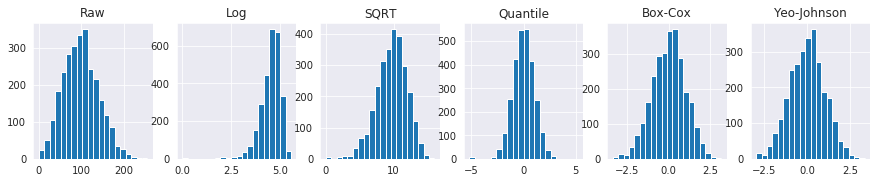

In [19]:
fig, axs = plt.subplots(1,6, figsize=(15,2.5))

quantile = QuantileTransformer(output_distribution='normal', random_state=127)
box_cox = PowerTransformer(method='box-cox')
yeo_johnson = PowerTransformer(method='yeo-johnson')

VALS = [y_train.values,
        np.log1p(y_train.values),
        np.sqrt(y_train.values),
        quantile.fit_transform(y_train.values),
        box_cox.fit_transform(y_train.values + 1e-9),
        yeo_johnson.fit_transform(y_train.values)]

TITLES = ['Raw', 'Log', 'SQRT', 'Quantile', 'Box-Cox', 'Yeo-Johnson']
SHAPIRO_ps = [shapiro(vals)[-1] for vals in VALS]

for i, vals in enumerate(VALS):
    axs.ravel()[i].hist(vals, bins=20)
    axs.ravel()[i].set_title(TITLES[i])
    
plt.show();

In [18]:
# identify the closest to normally-distributed
TITLES[np.array(SHAPIRO_ps).argmax()]

'Yeo-Johnson'

In [20]:
# choose your transformer here
transformer = quantile

In [21]:
transformer.fit(df[Y_COLS])
y_train.loc[:,Y_COLS], y_test.loc[:,Y_COLS] = transformer.transform(y_train), transformer.transform(y_test)

/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Split datasets by ecoregion
We want to explore model transferability between regions, so we'll train models independently on subsets of the data within a single ecoregion, as well as a model that is trained on all available ecoregions. 

In [22]:
ecoregions = [reg for reg in pd.unique(df.ecoregion3) if ecoreg_counts.loc[reg]['uuid'] > 20]

eco_train_idx = [x_train.loc[x_train.ecoregion3 == eco].index.values for eco in ecoregions]
eco_test_idx = [x_test.loc[x_test.ecoregion3 == eco].index.values for eco in ecoregions]

eco_xtrain_dfs = [x_train.loc[x_train.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytrain_dfs = [y_train.loc[idx].values.ravel() for idx in eco_train_idx]
eco_xtest_dfs = [x_test.loc[x_test.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytest_dfs = [y_test.loc[idx].values.ravel() for idx in eco_test_idx]

# append a "global" model that contains data from all ecoregions
ecoregions.append('all')
ecoregion_names = ['_'.join(x.split('_')[0:2]) for x in ecoregions]
eco_xtrain_dfs.append(x_train.drop(['ecoregion3'], axis=1))
eco_ytrain_dfs.append(y_train.values.ravel())
eco_xtest_dfs.append(x_test.drop(['ecoregion3'], axis=1))
eco_ytest_dfs.append(y_test.values.ravel())

## Scoring
We'll use Root Mean Square Error to evaluate model performance.

In [23]:
def rmse(pred, obs):
    # use our transformer to calculate RMSE on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return np.sqrt((np.square(obs-pred)).mean())

In [24]:
def nrmse(pred, obs):
    # use our transformer to calculate percent RMSE on the original data scale
    this_rmse = rmse(pred,obs)
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return this_rmse/obs.mean()

In [25]:
def mae(pred, obs):
    # use our transformer to calculate mean absolute error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1))
    obs = transformer.inverse_transform(obs.reshape(-1,1))
    
    return abs(pred - obs).mean()

In [26]:
def mape(pred, obs):
    # use our transformer to calculate mean absolute percent error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1))
    obs = transformer.inverse_transform(obs.reshape(-1,1))
    
    return abs(pred - obs).mean() / obs.mean()

In [27]:
def bias(pred, obs):
    # use our transformer to calculate mean bias on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1))
    obs = transformer.inverse_transform(obs.reshape(-1,1))
    
    return (pred - obs).mean()

In [90]:
def rel_bias(pred, obs):
    # use our transformer to calculate mean relative bias on the original data scale
    this_bias = bias(pred,obs)
    obs = transformer.inverse_transform(obs.reshape(-1,1))  
    
    return this_bias/obs.mean()

This helper function will calculate RMSE scores for each regionally-trained model and the global model on each ecoregion.

In [28]:
def get_score_df(models, metric=rmse, feature_selectors=None):
    regional_scores = []
    global_scores = []
    counts = []
    
    for i, mod in enumerate(models):
        X_test = x_scaler.transform(eco_xtest_dfs[i])
        if feature_selectors:
            X_test = feature_selectors[i].transform(X_test)
        y_test = eco_ytest_dfs[i]
        reg_score = metric(mod.predict(X_test), y_test)
        regional_scores.append(reg_score.round(3))
        
        if feature_selectors:
            X_test = x_scaler.transform(eco_xtest_dfs[i])
            X_test = feature_selectors[-1].transform(X_test)
        glob_score = metric(models[-1].predict(X_test), y_test)
        global_scores.append(glob_score.round(3))
        count = len(eco_xtrain_dfs[i] + eco_xtest_dfs[i])
        counts.append(count)
        
    data = list(zip(regional_scores, global_scores, counts))
    res_df = pd.DataFrame(data=data,
                          columns=['regional_model', 'global_model', 'n'],
                          index=ecoregion_names)
    
    return res_df

## Fit some models
For each type of model, we'll employ cross-validation to tune model hyperparameters, generating a tuned model for each ecoregion as well as a tuned model using all training data. We'll work our way through:

#### ElasticNet Regression
Linear model that employs a mix of L1 and L2 regularization to penalize model complexity

#### LASSO Regression  
Linear model that employs L1 regularization to penalize model complexity. We'll also work with a feature-selection process to fit models capped to an explicitly-predefined number of features.

#### K-Nearest Neighbor Regression

#### Random Forest Regression

#### Gradient Boosting Trees Regression

#### Support Vector Machine Regression

## ElasticNet (Linear Model)

In [29]:
best_lms = []

for i in range(len(ecoregions)):
    lm = ElasticNetCV(cv=3, random_state=127, n_jobs=-1, max_iter=1000000)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    lm.fit(X, y)
    best_lms.append(lm)

In [30]:
elastic_res = get_score_df(best_lms)
elastic_res

,regional_model,global_model,n
blue_mountains,11.267,11.871,104
coast_range,16.823,16.740,1580
north_cascades,16.309,16.267,443
cascades,13.558,14.529,613
klamath_mountains,14.627,15.917,275
eastern_cascades,12.213,13.830,203
northern_rockies,10.496,10.538,83
puget_lowland,8.714,7.191,122
willamette_valley,8.108,7.164,41
all,15.497,15.497,3473


In [31]:
coefs = np.array([lm.coef_ for lm in best_lms])
count_nonzero = [(~np.isclose(coef, 0, atol=1e-3)).sum() for coef in coefs]
coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,returns_per_m2,strat0_return-proportion,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,height_05-percentile,height_25-percentile,height_50-percentile,...,cover,potential_volume,stddev_height,surface_volume,aspect,elevation,slope,solar_radiation_index,kurtosis,skewness
blue_mountains,-0.089,0.126,0.32,0.19,0.503,-0.013,--,--,--,0.035,...,-0.417,-0.142,-0.443,0.408,-0.062,0.099,-0.143,-0.069,-1.221,0.153
coast_range,-0.003,0.081,-0.002,0.011,0.062,0.106,0.234,-0.008,-0.026,--,...,--,0.056,0.02,0.14,0.017,--,-0.03,0.02,-0.138,-0.221
north_cascades,--,--,--,--,--,0.034,--,--,--,0.012,...,0.011,0.146,--,--,--,--,--,--,--,-0.144
cascades,-0.029,0.055,--,0.022,0.055,0.058,0.048,-0.019,0.006,0.013,...,-0.076,0.219,0.074,0.227,-0.002,0.081,-0.019,0.005,-0.284,-0.153
klamath_mountains_california_high_north_coast_range,--,--,-0.087,-0.123,--,0.012,--,--,--,0.149,...,--,0.085,0.024,0.016,--,0.013,-0.001,0.019,--,-0.006
eastern_cascades_slopes_and_foothills,0.027,--,0.041,-0.008,0.022,0.095,--,--,--,0.096,...,--,0.106,0.072,0.112,-0.012,--,-0.131,-0.002,--,-0.159
northern_rockies,0.029,--,-0.057,--,--,0.014,--,--,--,--,...,--,0.227,0.018,--,0.007,--,0.066,-0.017,--,-0.248
puget_lowland,-0.012,--,-0.089,--,--,0.046,--,--,--,--,...,--,--,0.098,0.124,-0.066,--,-0.064,0.02,--,-0.078
willamette_valley,--,--,--,-0.041,--,--,0.087,--,0.084,0.203,...,--,0.141,0.046,0.088,--,--,--,--,--,--
all,--,--,-0.016,-0.034,--,0.028,0.055,--,--,0.029,...,--,0.115,0.02,0.083,--,0.04,-0.023,--,--,-0.183


## LASSO (Linear Model)
Starting with implicit feature selection via L1 regularization of coefficients.

In [32]:
best_lassos = []

for i in range(len(ecoregions)):
    lasso = LassoCV(cv=3, random_state=127, n_jobs=-1, max_iter=1000000, n_alphas=1000)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    lasso.fit(X, y)
    best_lassos.append(lasso)

In [33]:
lasso_res = get_score_df(best_lassos)
lasso_res

,regional_model,global_model,n
blue_mountains,11.315,11.908,104
coast_range,16.825,16.640,1580
north_cascades,14.072,15.530,443
cascades,13.520,14.191,613
klamath_mountains,14.851,16.193,275
eastern_cascades,11.948,13.404,203
northern_rockies,10.090,10.326,83
puget_lowland,8.422,7.131,122
willamette_valley,7.234,6.852,41
all,15.286,15.286,3473


In [34]:
coefs = np.array([lm.coef_ for lm in best_lassos])
coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,returns_per_m2,strat0_return-proportion,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,height_05-percentile,height_25-percentile,height_50-percentile,...,cover,potential_volume,stddev_height,surface_volume,aspect,elevation,slope,solar_radiation_index,kurtosis,skewness
blue_mountains,-0.088,--,0.275,0.194,0.523,--,--,--,--,0.025,...,-0.538,-0.141,-0.449,0.418,-0.062,0.092,-0.143,-0.062,-1.722,0.317
coast_range,-0.004,0.085,--,0.014,0.065,0.109,0.239,-0.008,-0.028,--,...,--,0.052,0.02,0.142,0.017,--,-0.03,0.02,-0.137,-0.223
north_cascades,--,--,--,--,--,0.026,--,--,--,--,...,0.001,--,--,--,--,--,--,--,--,-0.144
cascades,-0.029,0.061,--,0.016,0.047,0.048,0.03,-0.019,0.005,0.013,...,-0.064,0.218,0.073,0.234,-0.002,0.08,-0.019,0.004,-0.279,-0.157
klamath_mountains_california_high_north_coast_range,--,--,-0.081,-0.123,--,0.014,--,--,--,0.146,...,--,--,--,--,0.004,0.042,-0.024,0.027,--,-0.012
eastern_cascades_slopes_and_foothills,0.025,--,0.032,-0.002,0.013,0.091,--,--,--,0.081,...,--,0.05,0.061,0.11,-0.011,--,-0.128,--,--,-0.17
northern_rockies,0.08,0.015,-0.064,0.014,-0.012,--,--,--,--,--,...,--,0.206,--,--,0.014,--,0.085,-0.041,--,-0.241
puget_lowland,-0.004,--,-0.08,--,0.003,0.043,--,--,--,--,...,--,--,0.058,0.058,-0.061,--,-0.062,0.02,--,-0.081
willamette_valley,--,--,--,-0.041,--,--,0.077,--,0.051,0.282,...,--,0.208,--,--,--,--,--,--,--,--
all,--,--,-0.016,-0.035,--,0.032,0.058,-0.003,--,0.009,...,--,0.035,0.024,0.121,--,0.051,-0.035,0.002,0.004,-0.201


Now we'll explicitly define the maximum number of features to use for fitting a linear model. We'll trim features by iteratively increasing a threshold for coefficients using LASSO regression

In [35]:
MAX_FEATURES = 5
sfms = [] # transformers that filter X features
trimmed_lassos = [] # re-fit lasso regressions on the subset of the features

for i, lasso in enumerate(best_lassos):
    lasso = deepcopy(lasso)
    sfm = SelectFromModel(lasso, threshold=0.001)
    X = x_scaler.transform(eco_xtrain_dfs[i])
    Y = (eco_ytrain_dfs[i].ravel())
    sfm.fit(X, Y)
    n_features = sfm.transform(X).shape[1]

    # Reset the threshold till the number of features equals two.
    # Note that the attribute can be set directly instead of repeatedly
    # fitting the metatransformer.
    while n_features > MAX_FEATURES:
        sfm.threshold += 0.001
        X_transform = sfm.transform(X)
        n_features = X_transform.shape[1]
    
    sfms.append(sfm)
    try:
        trimmed_lassos.append(lasso.fit(sfm.transform(X), Y))
    except ValueError:
        print(ecoregion_names[i])
        raise

In [36]:
coefs = []
for i in range(len(ecoregions)):
    cols = np.zeros(eco_xtest_dfs[i].columns.shape)
    cols[sfms[i].get_support()] = trimmed_lassos[i].coef_
    coefs.append(cols)
    
coefs = np.array(coefs)

coef_df = pd.DataFrame(data=coefs.T,
                       columns=ecoregions,
                       index=eco_xtest_dfs[i].columns)
coef_df.values[np.isclose(coef_df.values, 0, atol=1e-3)] = np.nan
coef_df = coef_df.round(3)
coef_df = coef_df.dropna(how='all')
coef_df = coef_df.fillna('--')
coef_df.T

,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,height_25-percentile,height_50-percentile,height_75-percentile,height_95_percentile,cover,potential_volume,surface_volume,slope,kurtosis,skewness
blue_mountains,--,--,0.168,--,--,--,--,--,0.671,--,--,--,--,--,--
coast_range,--,--,--,--,0.065,--,--,--,0.569,--,--,0.209,--,-0.041,-0.275
north_cascades,--,--,--,0.026,--,--,--,--,0.824,0.001,--,--,--,--,-0.144
cascades,--,--,--,--,--,--,--,--,0.399,--,0.37,0.153,--,-0.318,-0.099
klamath_mountains_california_high_north_coast_range,-0.103,-0.154,--,--,--,--,0.158,0.33,0.377,--,--,--,--,--,--
eastern_cascades_slopes_and_foothills,--,--,--,0.087,--,--,--,--,0.719,--,--,0.195,-0.144,--,-0.216
northern_rockies,--,--,--,--,--,--,--,--,0.464,--,0.249,--,0.037,--,-0.267
puget_lowland,-0.071,--,--,--,--,--,--,0.369,0.669,--,--,--,-0.085,--,-0.135
willamette_valley,--,--,--,--,0.075,0.041,0.311,--,0.188,--,0.254,--,--,--,--
all,--,--,--,--,--,--,--,0.166,0.539,--,--,0.134,--,--,-0.171


In [37]:
trimmed_lasso_res = get_score_df(trimmed_lassos, feature_selectors=sfms)
trimmed_lasso_res

,regional_model,global_model,n
blue_mountains,11.741,11.933,104
coast_range,17.144,16.886,1580
north_cascades,14.072,15.533,443
cascades,13.922,15.441,613
klamath_mountains,15.474,17.550,275
eastern_cascades,11.472,14.551,203
northern_rockies,10.101,10.597,83
puget_lowland,8.646,8.158,122
willamette_valley,8.362,7.958,41
all,15.820,15.820,3473


## K-Nearest Neighbors Regression

In [38]:
# Set the parameters by cross-validation
knn_params = {'n_neighbors': [1,2,3,4,5,10,20],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan']}


knn_gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_knns = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    knn_gs.fit(X, y)
    best_fit = knn_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_knns.append(best_fit)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.3s finished


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.6s finished


In [39]:
knn_res = get_score_df(best_knns)
knn_res

,regional_model,global_model,n
blue_mountains,11.731,12.369,104
coast_range,17.859,17.318,1580
north_cascades,13.624,12.694,443
cascades,13.688,14.954,613
klamath_mountains,14.585,15.662,275
eastern_cascades,13.925,11.678,203
northern_rockies,13.454,11.463,83
puget_lowland,12.060,7.996,122
willamette_valley,16.009,12.821,41
all,15.335,15.335,3473


## Random Forest Regression

In [40]:
# Set the parameters by cross-validation
rf_params = {'n_estimators': [100, 500, 1000, 5000],
             'max_features': ['sqrt'],
             'max_depth': [3, 5, 10, 25, 50],
             'min_samples_leaf': [1,2,4],
             'bootstrap': [True]}


rf_gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_rfs = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i].ravel()
    rf_gs.fit(X, y)
    best_fit = rf_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_rfs.append(best_fit)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:    9.4s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   40.1s finished


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.1s finished


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:   11.5s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   27.0s finished


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.5s finished


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:    9.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   24.4s finished


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:    8.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:   12.1s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 117 out of 180 | elapsed:   10.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished


In [41]:
rf_res = get_score_df(best_rfs)
rf_res

,regional_model,global_model,n
blue_mountains,10.233,10.636,104
coast_range,16.453,15.929,1580
north_cascades,12.738,12.803,443
cascades,12.338,13.775,613
klamath_mountains,12.960,13.820,275
eastern_cascades,12.910,9.930,203
northern_rockies,13.168,10.067,83
puget_lowland,8.348,6.764,122
willamette_valley,15.396,9.612,41
all,14.113,14.113,3473


In [42]:
### Employing feature selection to try and improve random forest regression

In [43]:
importances = best_rfs[-1].feature_importances_
indices = np.argsort(importances)[::-1]
features = eco_xtrain_dfs[-1].columns[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(eco_xtrain_dfs[-1].shape[1]):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))

Feature ranking:
1. height_75-percentile (0.185717)
2. height_95_percentile (0.154744)
3. potential_volume (0.136675)
4. strat5_return-proportion (0.109406)
5. surface_volume (0.096945)
6. height_50-percentile (0.072815)
7. strat4_return-proportion (0.055639)
8. strat3_return-proportion (0.033935)
9. stddev_height (0.025548)
10. skewness (0.023470)
11. height_25-percentile (0.022709)
12. cover (0.015238)
13. strat2_return-proportion (0.015120)
14. strat0_return-proportion (0.013659)
15. kurtosis (0.011068)
16. strat1_return-proportion (0.005592)
17. slope (0.004665)
18. elevation (0.004064)
19. solar_radiation_index (0.003685)
20. returns_per_m2 (0.003632)
21. aspect (0.003321)
22. height_05-percentile (0.002352)


## Gradient Boosting Trees Regression

In [44]:
# Set the parameters by cross-validation
gb_params = {'n_estimators': [100, 500, 1000, 5000],
             'learning_rate': [0.01, 0.1],
             'max_depth': [2, 3, 4, 5, 10],
             'max_features': ['sqrt'] 
            }

gb_gs = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_gbs = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    gb_gs.fit(X, y)
    best_fit = gb_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_gbs.append(best_fit)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.4s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    6.7s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   16.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.8s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    3.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.6s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.4s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    3.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.9s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    2.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.5s finished


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    2.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  57 out of 120 | elapsed:    2.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   42.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.8s finished


In [45]:
gb_res = get_score_df(best_gbs)
gb_res

,regional_model,global_model,n
blue_mountains,9.990,11.201,104
coast_range,16.296,15.799,1580
north_cascades,12.509,13.973,443
cascades,12.093,13.665,613
klamath_mountains,13.558,14.011,275
eastern_cascades,12.085,9.767,203
northern_rockies,12.537,10.681,83
puget_lowland,10.667,6.213,122
willamette_valley,14.670,8.860,41
all,14.201,14.201,3473


In [46]:
### Employing feature selection to try and improve gradient boosting regression

## Support Vector Machines Regression

In [47]:
# Set the parameters by cross-validation
svm_params = {'kernel': ['linear', 'rbf'],
              'gamma': ['scale', 'auto'],
              'C': [0.1,1,10,100,1000]
              }

svm_gs = GridSearchCV(estimator=SVR(), param_grid=svm_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

best_svms = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    svm_gs.fit(X, y)
    best_fit = svm_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_svms.append(best_fit)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.7min finished


In [48]:
svm_res = get_score_df(best_svms)
svm_res

,regional_model,global_model,n
blue_mountains,10.965,11.853,104
coast_range,16.838,16.808,1580
north_cascades,15.830,14.968,443
cascades,13.651,13.514,613
klamath_mountains,15.518,15.128,275
eastern_cascades,18.297,11.432,203
northern_rockies,9.576,11.193,83
puget_lowland,11.337,8.196,122
willamette_valley,9.195,11.668,41
all,15.043,15.043,3473


In [49]:
### Employing feature selection to try and improve support vector regression

In [50]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

def scatter_graphs(model_dict):
    names = MODELS.keys()
    EXTEND_PCT = 0.10
    
    fig, axs = plt.subplots(len(ecoregion_names), len(names), 
                            sharex=True, sharey=True,
                            figsize=(11,15)
                           )
    
    all_obs = transformer.inverse_transform(eco_ytest_dfs[-1].reshape(-1,1))
    obs_min = all_obs.min()
    obs_max = all_obs.max()
    rng = obs_max - obs_min
        
    for i, ecoreg in enumerate(ecoregion_names):
        observed = transformer.inverse_transform(eco_ytest_dfs[i].reshape(-1,1))
        
        for j, name in enumerate(names):
            axs[0,j].set_title(name)
            axs[i,0].set_ylabel('\n'.join(ecoreg.split('_')).upper())
            axs[i,j].set_xlim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_ylim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_aspect('equal')
            
            if name == 'LASSO_{}'.format(MAX_FEATURES):
                predicted = MODELS[name][-1].predict(sfms[-1].transform(x_scaler.transform(eco_xtest_dfs[i])))
            else:
                predicted = MODELS[name][-1].predict(x_scaler.transform(eco_xtest_dfs[i]))
            
            predicted = transformer.inverse_transform(predicted.reshape(-1,1))
            axs[i,j].scatter(observed, predicted, s=0.5)
            axs[i,j].plot((obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng), 
                          (obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng),
                         color='k', lw=0.5)
            
    plt.tight_layout(pad=0.5)

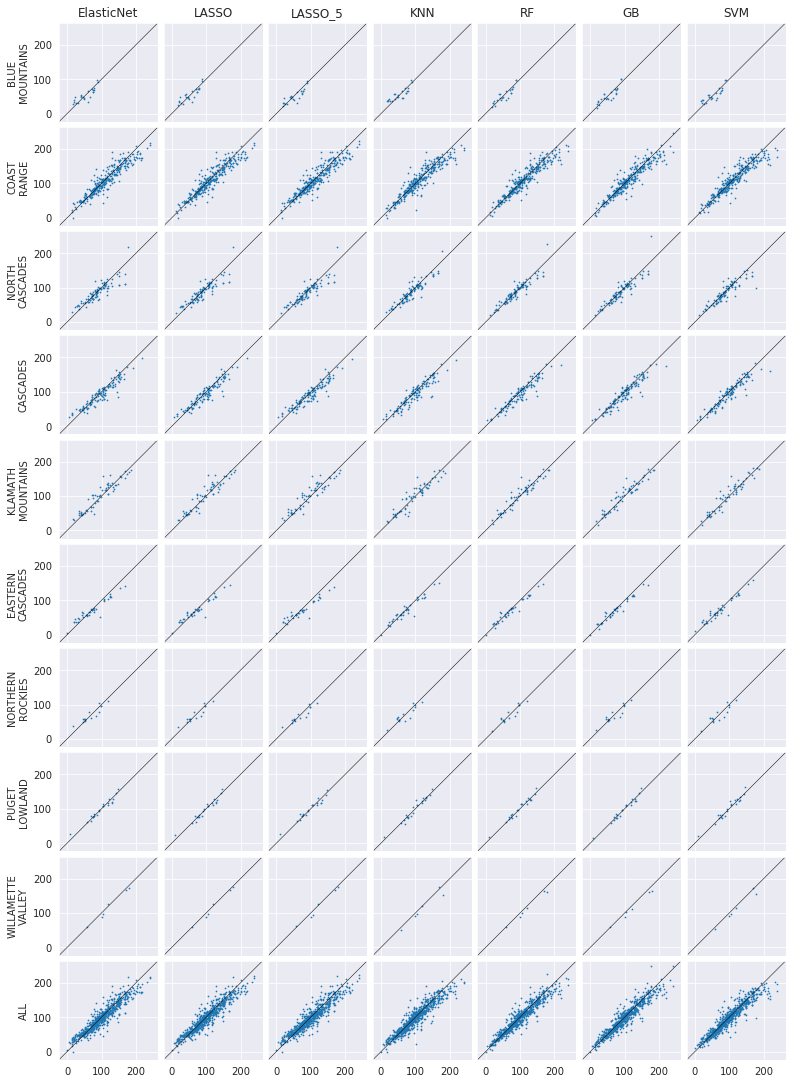

In [51]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

scatter_graphs(MODELS)

## View scores for regional and global models

In [52]:
MODEL_NAMES = ['ElasticNet', 'LASSO', 'LASSO_{}'.format(MAX_FEATURES), 'KNN', 'RF', 'GB', 'SVM']
BEST_MODELS = [best_lms, best_lassos, trimmed_lassos, best_knns, best_rfs, best_gbs, best_svms]

def compare_models(metric):
    score_dfs = []
    for name, best_models in list(zip(MODEL_NAMES, BEST_MODELS)):
        if name == 'LASSO_{}'.format(MAX_FEATURES):
            score_df = get_score_df(best_models, metric, sfms) 
            score_dfs.append(score_df)
        else:
            score_df = get_score_df(best_models, metric) 
            score_dfs.append(score_df)
        
    counts = np.array(score_dfs[-1]['n'].values)
    regional_data = np.array([df['regional_model'].values for df in score_dfs])
    global_data = np.array([df['global_model'].values for df in score_dfs])
    
    return regional_data, global_data, counts

In [53]:
def highlight_best(s):
    '''
    highlight the closest value to zero in a Series yellow.
    '''
    lowest_idx = abs(s).idxmin()
    return ['background-color: yellow' if idx==lowest_idx else '' for idx in s.index]

In [54]:
print('Regional Models, RMSE')
regional_data, global_data, counts = compare_models(rmse)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(regional_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=regional_scores.columns[:-1])
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, RMSE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,11.3,11.3,11.7,11.7,10.2,10.0,11.0,104
coast_range,16.8,16.8,17.1,17.9,16.5,16.3,16.8,"1,580"
north_cascades,16.3,14.1,14.1,13.6,12.7,12.5,15.8,443
cascades,13.6,13.5,13.9,13.7,12.3,12.1,13.7,613
klamath_mountains,14.6,14.9,15.5,14.6,13.0,13.6,15.5,275
eastern_cascades,12.2,11.9,11.5,13.9,12.9,12.1,18.3,203
northern_rockies,10.5,10.1,10.1,13.5,13.2,12.5,9.6,83
puget_lowland,8.7,8.4,8.6,12.1,8.3,10.7,11.3,122
willamette_valley,8.1,7.2,8.4,16.0,15.4,14.7,9.2,41
all,15.5,15.3,15.8,15.3,14.1,14.2,15.0,"3,473"


In [55]:
print('Regional Models, RMSE%')
regional_data, global_data, counts = compare_models(nrmse)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(regional_scores
 .style
 .format("{:.0%}", subset=regional_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, RMSE%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,21%,21%,22%,22%,19%,19%,21%,104
coast_range,15%,15%,15%,16%,15%,14%,15%,"1,580"
north_cascades,18%,16%,16%,15%,14%,14%,18%,443
cascades,14%,14%,14%,14%,12%,12%,14%,613
klamath_mountains,15%,15%,16%,15%,14%,14%,16%,275
eastern_cascades,17%,16%,16%,19%,18%,17%,25%,203
northern_rockies,15%,15%,15%,20%,19%,18%,14%,83
puget_lowland,9%,9%,9%,12%,9%,11%,12%,122
willamette_valley,7%,6%,7%,13%,13%,12%,8%,41
all,16%,15%,16%,15%,14%,14%,15%,"3,473"


In [56]:
print('Regional Models, Bias')
regional_data, global_data, counts = compare_models(bias)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(regional_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=regional_scores.columns[:-1])
 .apply(highlight_best, axis=1, subset=regional_scores.columns[:-1]))

Regional Models, Bias


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,0.3,0.3,3.2,3.7,1.9,1.6,-1.2,104
coast_range,-2.5,-2.5,-2.6,-2.1,-1.6,-1.6,-2.0,"1,580"
north_cascades,-2.5,-1.3,-1.3,-1.5,-1.9,-1.5,-1.4,443
cascades,-0.0,-0.1,-0.3,-0.7,-0.8,-1.1,-0.3,613
klamath_mountains,1.7,2.2,2.5,0.3,0.5,1.2,3.8,275
eastern_cascades,-0.8,-0.7,-0.5,-1.3,-1.5,-1.2,1.5,203
northern_rockies,2.2,1.6,1.3,2.1,2.7,2.7,1.5,83
puget_lowland,1.7,1.7,2.9,3.5,2.9,2.1,4.2,122
willamette_valley,-3.8,-3.7,-3.7,-5.7,-9.3,-9.8,-3.8,41
all,-1.0,-0.9,-1.1,-1.2,-0.7,-0.8,-0.6,"3,473"


In [57]:
print('Regional Models, MAE')
regional_data, global_data, counts = compare_models(mae)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(regional_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=regional_scores.columns[:-1])
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, MAE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,9.8,10.0,9.8,9.9,8.3,8.2,9.5,104
coast_range,12.2,12.2,12.5,12.7,11.6,11.6,12.0,"1,580"
north_cascades,11.2,10.5,10.5,10.2,9.3,9.5,10.5,443
cascades,10.2,10.2,10.6,10.3,9.4,9.2,10.2,613
klamath_mountains,11.3,11.3,11.8,11.0,9.3,9.6,11.3,275
eastern_cascades,8.5,8.2,7.8,10.0,8.8,8.8,11.5,203
northern_rockies,9.3,8.8,8.9,11.5,11.6,10.9,7.9,83
puget_lowland,7.0,6.8,6.7,8.7,7.0,9.0,8.9,122
willamette_valley,7.1,6.3,7.7,13.3,11.7,10.5,8.1,41
all,11.4,11.3,11.9,11.1,10.0,10.0,10.5,"3,473"


In [58]:
print('Regional Models, MAPE')
regional_data, global_data, counts = compare_models(mape)
regional_scores = pd.DataFrame(data=np.vstack((regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(regional_scores
 .style
 .format("{:.0%}", subset=regional_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .highlight_min(color='yellow', axis=1, subset=regional_scores.columns[:-1]))

Regional Models, MAPE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,19%,19%,18%,19%,16%,16%,18%,104
coast_range,11%,11%,11%,11%,10%,10%,11%,"1,580"
north_cascades,13%,12%,12%,12%,10%,11%,12%,443
cascades,10%,10%,11%,10%,10%,9%,10%,613
klamath_mountains,12%,12%,12%,12%,10%,10%,12%,275
eastern_cascades,12%,11%,11%,14%,12%,12%,16%,203
northern_rockies,14%,13%,13%,17%,17%,16%,12%,83
puget_lowland,7%,7%,7%,9%,7%,9%,9%,122
willamette_valley,6%,5%,6%,11%,10%,9%,7%,41
all,12%,11%,12%,11%,10%,10%,10%,"3,473"


In [59]:
print('Global Models, RMSE')
regional_data, global_data, counts = compare_models(rmse)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(global_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=global_scores.columns[:-1])
 .highlight_min(color='yellow', axis=1, subset=global_scores.columns[:-1]))

Global Models, RMSE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,11.9,11.9,11.9,12.4,10.6,11.2,11.9,104
coast_range,16.7,16.6,16.9,17.3,15.9,15.8,16.8,"1,580"
north_cascades,16.3,15.5,15.5,12.7,12.8,14.0,15.0,443
cascades,14.5,14.2,15.4,15.0,13.8,13.7,13.5,613
klamath_mountains,15.9,16.2,17.6,15.7,13.8,14.0,15.1,275
eastern_cascades,13.8,13.4,14.6,11.7,9.9,9.8,11.4,203
northern_rockies,10.5,10.3,10.6,11.5,10.1,10.7,11.2,83
puget_lowland,7.2,7.1,8.2,8.0,6.8,6.2,8.2,122
willamette_valley,7.2,6.9,8.0,12.8,9.6,8.9,11.7,41
all,15.5,15.3,15.8,15.3,14.1,14.2,15.0,"3,473"


In [60]:
print('Global Models, RMSE%')
regional_data, global_data, counts = compare_models(nrmse)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(global_scores
 .style
 .format("{:.0%}", subset=global_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .highlight_min(color='yellow', axis=1, subset=global_scores.columns[:-1]))

Global Models, RMSE%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,22%,22%,22%,23%,20%,21%,22%,104
coast_range,15%,15%,15%,15%,14%,14%,15%,"1,580"
north_cascades,18%,18%,18%,14%,14%,16%,17%,443
cascades,15%,14%,16%,15%,14%,14%,14%,613
klamath_mountains,16%,17%,18%,16%,14%,15%,16%,275
eastern_cascades,19%,18%,20%,16%,14%,14%,16%,203
northern_rockies,15%,15%,15%,17%,15%,16%,16%,83
puget_lowland,7%,7%,8%,8%,7%,6%,8%,122
willamette_valley,6%,6%,6%,10%,8%,7%,10%,41
all,16%,15%,16%,15%,14%,14%,15%,"3,473"


In [61]:
print('Global Models, Bias')
regional_data, global_data, counts = compare_models(bias)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(global_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=global_scores.columns[:-1])
 .apply(highlight_best, axis=1, subset=global_scores.columns[:-1]))

Global Models, Bias


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,1.1,1.5,-2.4,2.3,0.3,-0.1,0.8,104
coast_range,-1.8,-1.9,-0.8,-1.9,-0.8,-1.1,-1.1,"1,580"
north_cascades,-1.1,-0.7,-1.9,-0.2,0.1,0.2,-1.4,443
cascades,-3.1,-2.8,-4.3,-3.3,-4.0,-3.7,-2.9,613
klamath_mountains,5.2,5.8,6.2,3.0,4.8,4.6,5.6,275
eastern_cascades,-0.9,-0.6,-2.9,-1.1,-1.6,-1.7,0.1,203
northern_rockies,1.3,1.5,-0.7,1.1,1.1,1.7,1.3,83
puget_lowland,1.5,1.2,2.1,2.4,2.9,1.8,3.5,122
willamette_valley,-3.8,-3.3,-3.0,-7.7,-7.6,-7.5,-8.4,41
all,-1.0,-0.9,-1.1,-1.2,-0.7,-0.8,-0.6,"3,473"


In [62]:
print('Global Models, MAE')
regional_data, global_data, counts = compare_models(mae)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(global_scores
 .style
 .format("{:,.0f}", subset=['n'])
 .format("{:,.1f}", subset=global_scores.columns[:-1])
 .highlight_min(color='yellow', axis=1, subset=global_scores.columns[:-1]))

Global Models, MAE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,10.0,9.9,9.6,10.3,8.9,9.5,9.9,104
coast_range,12.3,12.2,12.7,12.6,11.4,11.1,11.7,"1,580"
north_cascades,11.5,11.3,11.0,9.3,8.9,9.3,9.7,443
cascades,11.0,10.8,12.1,10.8,9.9,9.8,9.5,613
klamath_mountains,12.2,12.4,14.0,11.7,10.1,10.3,11.0,275
eastern_cascades,10.3,10.0,10.9,8.6,7.4,7.1,8.3,203
northern_rockies,8.8,8.6,8.9,9.7,8.1,8.4,9.7,83
puget_lowland,5.8,5.9,6.9,6.1,5.7,5.3,6.5,122
willamette_valley,6.1,5.3,7.0,9.7,7.6,7.5,9.1,41
all,11.4,11.3,11.9,11.1,10.0,10.0,10.5,"3,473"


In [63]:
print('Global Models, MAPE')
regional_data, global_data, counts = compare_models(mape)
global_scores = pd.DataFrame(data=np.vstack((global_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(global_scores
 .style
 .format("{:.0%}", subset=global_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .highlight_min(color='yellow', axis=1, subset=global_scores.columns[:-1]))

Global Models, MAPE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,19%,19%,18%,20%,17%,18%,19%,104
coast_range,11%,11%,11%,11%,10%,10%,10%,"1,580"
north_cascades,13%,13%,12%,10%,10%,11%,11%,443
cascades,11%,11%,12%,11%,10%,10%,10%,613
klamath_mountains,13%,13%,14%,12%,10%,11%,11%,275
eastern_cascades,14%,14%,15%,12%,10%,10%,12%,203
northern_rockies,13%,12%,13%,14%,12%,12%,14%,83
puget_lowland,6%,6%,7%,6%,6%,6%,7%,122
willamette_valley,5%,4%,6%,8%,6%,6%,7%,41
all,12%,11%,12%,11%,10%,10%,10%,"3,473"


In [92]:
print('Global vs. Regional Models, ΔRMSE')
regional_data, global_data, counts = compare_models(rmse)
diff_scores = pd.DataFrame(data=np.vstack((global_data - regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(diff_scores.iloc[:-1]
 .style
 .format("{:,.1f}", subset=diff_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .bar(subset=diff_scores.columns[:-1], color=['orange', 'blue'], align='mid', vmin=-8, vmax=8))

Global vs. Regional Models, ΔRMSE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,0.6,0.6,0.2,0.6,0.4,1.2,0.9,104
coast_range,-0.1,-0.2,-0.3,-0.5,-0.5,-0.5,-0.0,"1,580"
north_cascades,-0.0,1.5,1.5,-0.9,0.1,1.5,-0.9,443
cascades,1.0,0.7,1.5,1.3,1.4,1.6,-0.1,613
klamath_mountains,1.3,1.3,2.1,1.1,0.9,0.5,-0.4,275
eastern_cascades,1.6,1.5,3.1,-2.2,-3.0,-2.3,-6.9,203
northern_rockies,0.0,0.2,0.5,-2.0,-3.1,-1.9,1.6,83
puget_lowland,-1.5,-1.3,-0.5,-4.1,-1.6,-4.5,-3.1,122
willamette_valley,-0.9,-0.4,-0.4,-3.2,-5.8,-5.8,2.5,41


In [93]:
print('Global vs. Regional Models, ΔRMSE%')
regional_data, global_data, counts = compare_models(nrmse)
diff_scores = pd.DataFrame(data=np.vstack((global_data - regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(diff_scores.iloc[:-1]
 .style
 .format("{:,.1%}", subset=diff_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .bar(subset=diff_scores.columns[:-1], color=['orange', 'blue'], align='mid', vmin=-0.2, vmax=0.2))

Global vs. Regional Models, ΔRMSE%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,1.1%,1.2%,0.3%,1.2%,0.8%,2.3%,1.7%,104
coast_range,-0.1%,-0.2%,-0.2%,-0.5%,-0.5%,-0.4%,0.0%,"1,580"
north_cascades,-0.1%,1.7%,1.7%,-1.0%,0.1%,1.6%,-1.0%,443
cascades,1.0%,0.7%,1.6%,1.3%,1.5%,1.6%,-0.2%,613
klamath_mountains,1.3%,1.4%,2.1%,1.1%,0.9%,0.5%,-0.4%,275
eastern_cascades,2.2%,2.0%,4.3%,-3.1%,-4.1%,-3.2%,-9.5%,203
northern_rockies,0.1%,0.3%,0.7%,-2.9%,-4.5%,-2.7%,2.4%,83
puget_lowland,-1.6%,-1.3%,-0.5%,-4.2%,-1.6%,-4.6%,-3.3%,122
willamette_valley,-0.7%,-0.3%,-0.4%,-2.6%,-4.7%,-4.7%,2.1%,41


In [94]:
print('Global vs. Regional Models, ΔMAE')
regional_data, global_data, counts = compare_models(mae)
diff_scores = pd.DataFrame(data=np.vstack((global_data - regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(diff_scores.iloc[:-1]
 .style
 .format("{:,.1f}", subset=diff_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .bar(subset=diff_scores.columns[:-1], color=['orange', 'blue'], align='mid', vmin=-8, vmax=8))

Global vs. Regional Models, ΔMAE


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,0.1,-0.1,-0.2,0.4,0.6,1.2,0.4,104
coast_range,0.1,0.0,0.2,-0.1,-0.2,-0.5,-0.3,"1,580"
north_cascades,0.3,0.8,0.5,-0.9,-0.4,-0.2,-0.8,443
cascades,0.8,0.6,1.5,0.6,0.5,0.6,-0.7,613
klamath_mountains,0.9,1.1,2.1,0.6,0.8,0.7,-0.3,275
eastern_cascades,1.9,1.8,3.1,-1.4,-1.4,-1.7,-3.2,203
northern_rockies,-0.6,-0.2,0.0,-1.9,-3.4,-2.4,1.7,83
puget_lowland,-1.2,-0.9,0.2,-2.6,-1.2,-3.7,-2.4,122
willamette_valley,-1.0,-1.0,-0.7,-3.6,-4.1,-3.0,0.9,41


In [95]:
print('Global vs. Regional Models, Δbias%')
regional_data, global_data, counts = compare_models(rel_bias)
diff_scores = pd.DataFrame(data=np.vstack((global_data - regional_data, counts)).T,
                             columns=MODEL_NAMES + ['n'],
                             index=ecoregion_names)
(diff_scores.iloc[:-1]
 .style
 .format("{:,.1%}", subset=diff_scores.columns[:-1])
 .format("{:,.0f}", subset=['n'])
 .bar(subset=diff_scores.columns[:-1], color=['orange', 'blue'], align='mid', vmin=-0.4, vmax=0.4))

Global vs. Regional Models, Δbias%


,ElasticNet,LASSO,LASSO_5,KNN,RF,GB,SVM,n
blue_mountains,1.5%,2.2%,-10.6%,-2.7%,-3.1%,-3.1%,3.9%,104
coast_range,0.6%,0.5%,1.6%,0.2%,0.7%,0.4%,0.8%,"1,580"
north_cascades,1.5%,0.6%,-0.7%,1.5%,2.3%,1.9%,0.0%,443
cascades,-3.2%,-2.8%,-4.1%,-2.7%,-3.1%,-2.6%,-2.6%,613
klamath_mountains,3.6%,3.7%,3.8%,2.7%,4.4%,3.6%,1.9%,275
eastern_cascades,-0.2%,0.1%,-3.3%,0.3%,-0.3%,-0.8%,-1.9%,203
northern_rockies,-1.2%,-0.1%,-2.8%,-1.4%,-2.4%,-1.4%,-0.4%,83
puget_lowland,-0.3%,-0.4%,-0.8%,-1.2%,0.0%,-0.4%,-0.7%,122
willamette_valley,0.0%,0.3%,0.5%,-1.6%,1.5%,2.0%,-3.8%,41


In [67]:
METRIC = 'top_height'

MODELS = {'ElasticNet': best_lms,
          'LASSO': best_lassos,
          'LASSO{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

pickle.dump(x_scaler, 
            open('../models/{}/sklearn/x_scaler.pkl'.format(METRIC), 'wb'))
pickle.dump(transformer, 
            open('../models/{}/sklearn/y_scaler.pkl'.format(METRIC), 'wb'))

for i in range(len(ecoregion_names)):
    for key in MODELS.keys():
        fname = ecoregion_names[i] + '_{}.pkl'.format(key)
        path_to_file = '../models/{}/sklearn/{}'.format(METRIC, fname)
        pickle.dump(MODELS[key][i], 
                    open(path_to_file, 'wb'))
        
        if key == 'LASSO{}'.format(MAX_FEATURES):
            sfm_name = ecoregion_names[i] + '_LASSO{}_featureselect.pkl'.format(MAX_FEATURES)
            path_to_file = '../models/{}/sklearn/{}'.format(METRIC, sfm_name)
            pickle.dump(sfms[i], 
                        open(path_to_file, 'wb'))